In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

In [2]:
df=pd.read_csv('acumulados-003.csv', parse_dates=True)

In [3]:
df.fillna(0, inplace=True)

In [4]:
df['FECHA'] = pd.to_datetime(df['FECHA'])

In [5]:
#df=df[df['CCAA']=='VC']

In [6]:
df

,CCAA,FECHA,CASOS,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,2020-02-20,0.0,0.0,0.0,0.0,0.0
1,AR,2020-02-20,0.0,0.0,0.0,0.0,0.0
2,AS,2020-02-20,0.0,0.0,0.0,0.0,0.0
3,IB,2020-02-20,1.0,0.0,0.0,0.0,0.0
4,CN,2020-02-20,1.0,0.0,0.0,0.0,0.0
5,CB,2020-02-20,0.0,0.0,0.0,0.0,0.0
6,CM,2020-02-20,0.0,0.0,0.0,0.0,0.0
7,CL,2020-02-20,0.0,0.0,0.0,0.0,0.0
8,CT,2020-02-20,0.0,0.0,0.0,0.0,0.0
9,CE,2020-02-20,0.0,0.0,0.0,0.0,0.0


In [7]:
df = df.groupby('FECHA')['Fallecidos'].sum().to_frame()

In [8]:
df=df.sort_values(by='Fallecidos')

In [9]:
df['Index'] = range(1, len(df) + 1)

In [10]:
df=df.set_index('Index')

In [11]:
df['Dif. fallecidos'] = df['Fallecidos'] - df['Fallecidos'].shift(1)

In [12]:
df.fillna(0, inplace=True)

In [13]:
df.drop('Fallecidos', axis=1, inplace=True)

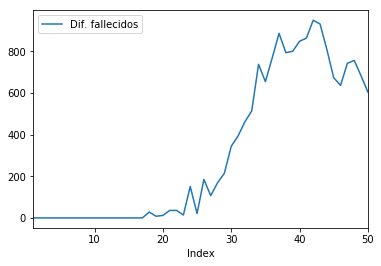

In [14]:
df.plot()

In [15]:
yData=df[df['Dif. fallecidos']>0].to_numpy()
yData=yData.reshape(yData.size)
xData=np.arange(yData.size)

In [16]:
yData

array([ 28.,   8.,  12.,  36.,  36.,  14., 151.,  21., 185., 107., 169.,
       215., 344., 394., 462., 514., 738., 655., 769., 887., 794., 801.,
       849., 864., 950., 932., 809., 674., 637., 743., 757., 683., 605.])

In [17]:
#Example of regression function - Polynomial
#def func(x, a ,b, c, d):
#    return a*np.exp(b*x)
#    return a+ b*x + c*pow(x,2)+ d*pow(x,3) #+ e*pow(x,4) + f*pow(x,5) + g*pow(x,6)

In [18]:
#Example of regression function
#def func(x, amp, cen, wid):
#    return amp * np.exp(-(x-cen)**2 / wid)

In [19]:
#Regression function - skew normal
def func(x, sigmag, mu, alpha,a):
    c = 0
    #normal distribution
    normpdf = (1/(sigmag*np.sqrt(2*np.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    normcdf = (0.5*(1+erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

In [20]:
popt, pcov = curve_fit(func, xData, yData, p0=(1,1,1,20000))
print(popt)
print(pcov)

[1.72978924e+01 1.44479217e+01 3.34497627e+00 2.23581054e+04]
[[ 6.22695758e+00 -1.37171935e+00  2.06076686e+00  4.30798448e+03]
 [-1.37171935e+00  3.73966843e-01 -4.79455567e-01 -9.03912386e+02]
 [ 2.06076686e+00 -4.79455567e-01  7.65806214e-01  1.35311817e+03]
 [ 4.30798448e+03 -9.03912386e+02  1.35311817e+03  3.21345899e+06]]


In [21]:
xFit = np.arange(0.0, 40, 1)

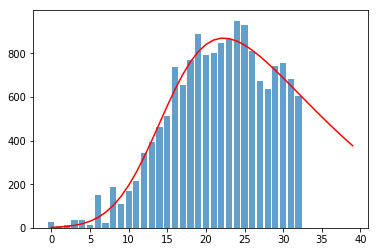

In [22]:
#plt.plot(xData, yData, 'bo', label='experimental-data')
plt.bar(xData, yData, align='center', alpha=0.7)
plt.plot(xFit, func(xFit, *popt), 'r')
plt.show()

In [23]:
#Prediction for the next day:
func(yData.size, *popt)

580.1389271415577